In [15]:
import os
from io import StringIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
req = requests.get(url)
data = StringIO(req.text)
df = pd.read_csv(data)
#df.groupby('countriesAndTerritories').plot(x='dateRep',y='cases')

grouped = df.groupby('countriesAndTerritories')
    
def get_country_data(country):
    """ Returns a pd (data) with a contracted version of the data for
    a given 'country' (country = string)"""
    data = grouped.get_group(country)
    data = data.drop(columns = ["popData2018","countryterritoryCode", "geoId", "countriesAndTerritories","dateRep", "continentExp"])

    data = data.iloc[::-1]
    data = data.reset_index()
# Create a new column that runs as the index, starting on the first date of data available (x=1)
    data['day_counter'] = data.index    
# And now add cumulative sums
    data['sum_cases'] = data['cases'].cumsum()
    data['sum_deaths'] = data['deaths'].cumsum()
    return(data)

def analyze_data(country):
    """returns analysis of the pd named 'country' (country = pd)"""

    total_cases = country['cases'].sum()
    total_deaths =  country['deaths'].sum()

    #Gives row when number of deaths is highest
    max_deaths_info = country.loc[country['deaths'].idxmax()]

    #Gives row when number of cases is highest
    max_cases_info = country.loc[country['cases'].idxmax()]

    #Gives data for day the first case was detected
    #Looks through the dataframe for the first "1" in the cases column, then returns the entire row
    first_day_data = country.iloc[country.loc[country['cases']>0].iloc[[0,]].index[0],]

    #Number of days between first case and max cases
    #Y/M/D format by default, thanks python
    #days_to_max_deaths = (date(max_deaths_info[3], max_deaths_info[2],max_deaths_info[1]) - date(first_day_data[3],first_day_data[2], first_day_data[1])).days
    #days_to_max_cases = (date(max_cases_info[3], max_cases_info[2],max_cases_info[1]) - date(first_day_data[3],first_day_data[2], first_day_data[1])).days

    return total_cases, total_deaths
   


spain = get_country_data("Spain")
print(spain)
print(analyze_data(spain))



#countrylist = ["Spain","France"]

#for n in countrylist:
#    print(analyze_data(n))

#This doesn't work for some reason? Fix later
# #Get a list of countries
# countrylist = df.loc[: , "countriesAndTerritories"]
# countrylist = countrylist.unique()

     index  day  month  year  cases  deaths  day_counter  sum_cases  sum_deaths
0    10371   31     12  2019      0       0            0          0           0
1    10370    1      1  2020      0       0            1          0           0
2    10369    2      1  2020      0       0            2          0           0
3    10368    3      1  2020      0       0            3          0           0
4    10367    4      1  2020      0       0            4          0           0
..     ...  ...    ...   ...    ...     ...          ...        ...         ...
107  10264   16      4  2020   5092     523          107     177633       18579
108  10263   17      4  2020   5183     551          108     182816       19130
109  10262   18      4  2020   5252     348          109     188068       19478
110  10261   19      4  2020   3658     565          110     191726       20043
111  10260   20      4  2020   4218     410          111     195944       20453

[112 rows x 9 columns]
(195944, 20453)


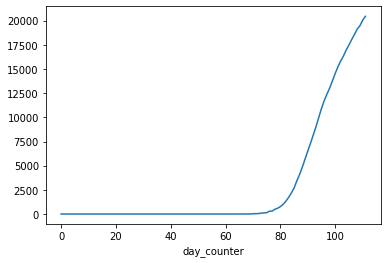

In [16]:
spain.set_index('day_counter')['sum_deaths'].plot()


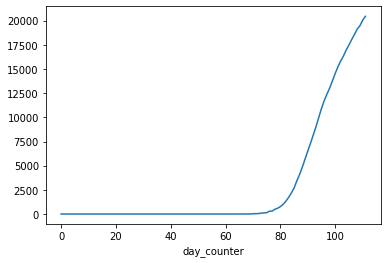

In [17]:
spain.set_index('day_counter')['sum_deaths'].plot()

## Data Analysis

Let's start doing a scientific anlaysis of some of the data in our dataframe. We want to:
* fit the data to a simple model (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5348083/)
* infer data from the model/old data
* Compare results for different countries


# Function fitting 
  See plot_curve_fit notebook.
  We need to obtain our column data (sum_cases) as a numpy array. This is simple to do using the to_numpy method 
  ```python
  cases = spain[["sum_cases"]].to_numpy() 
  ```

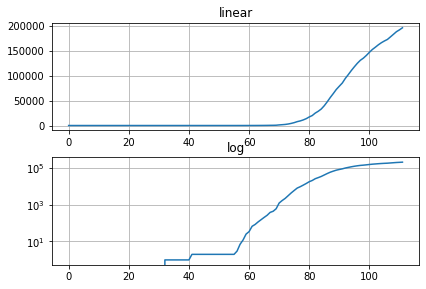

In [45]:
y = spain[["sum_cases"]].to_numpy() 
x = spain[["day_counter"]].to_numpy()
plt.plot(cases)
# linear
plt.subplot(211)
plt.plot(x, y)
plt.yscale('linear')
plt.title('linear')
plt.grid(True)


# log
plt.subplot(212)
plt.plot(x, y)
plt.yscale('log')
plt.title('log')
plt.grid(True)


# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(plt.NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()


Now we are going to do the most simple fit, an exponential



In [0]:
x_data = np.squeeze(x)
y_data = np.squeeze(y)

In [77]:
from scipy import optimize

def malthus_f(x, a, b):
  """Fit to a Malthusian equation of exponential growth
       N(t) = N_0 exp(\lambda t)
       a = N_0, initial population
       b = \lambda
   """  
  return a * np.exp(b * x)

def subexp_f(x, a, b, c):
  """Fit to a subexponential growth solution
    see: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5348083/
    dN(t)/dt = r N(t)^p, now 0<p<1 (subexponential growth)
       N(t) = (r/m t + A)^m
       where p = 1 - 1/m
       A = N(0)^(1/m)

       a = r
       b = m
       c = A
   """ 
  return ((a/b) * x + c )**m   

params, params_covariance = optimize.curve_fit(malthus_f, x_data[xmin:xmax], y_data[xmin:xmax],
                                               p0=[0, 0])
params, params_covariance = optimize.curve_fit(subexp_f, x_data[xmin:xmax], y_data[xmin:xmax],
                                               p0=[0, 0])

print(params)
print(params_covariance)

[3.81419799e-05 2.49953733e-01]
[[ 1.70388547e-10 -5.76385903e-08]
 [-5.76385903e-08  1.95105673e-05]]


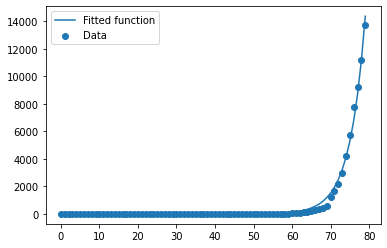

In [72]:
plt.figure(figsize=(6, 4))
plt.scatter(x_data[xmin:xmax], y_data[xmin:xmax], label='Data')
plt.plot(x_data[xmin:xmax], malthus_f(x_data, params[0], params[1])[xmin:xmax],
         label='Fitted function')

plt.legend(loc='best')

plt.show()